In [8]:
!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc
!pip install qiskit qiskit-aer pylatexenc

Initial state prepared on Alice’s qubit (Qubit 0):


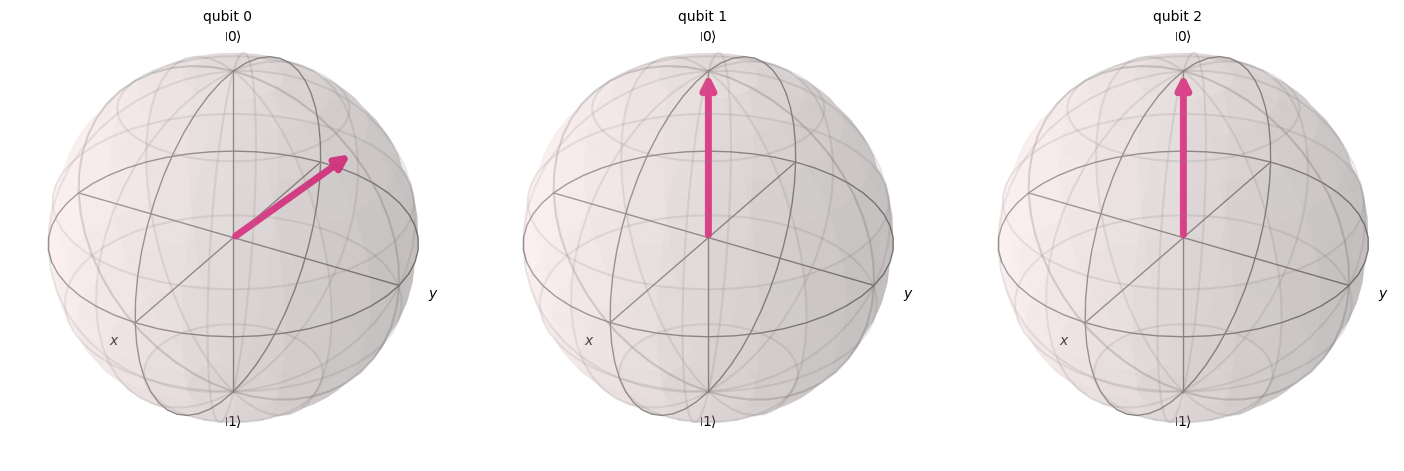


Circuit with measurement and conditional corrections:


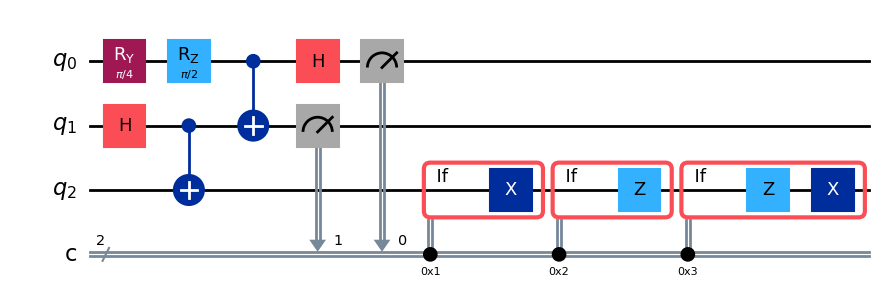

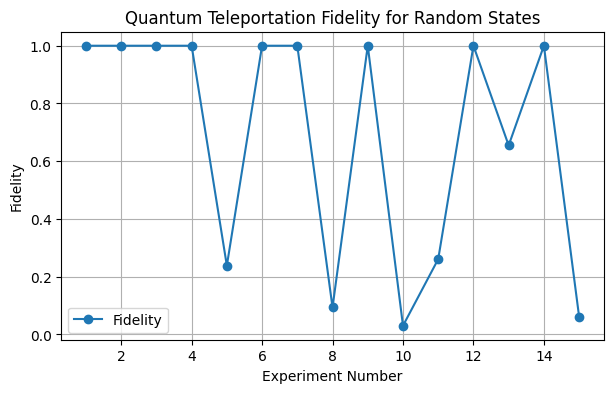

Average Fidelity (noiseless): 0.689297

1️⃣ Initial state (Qubit 0):


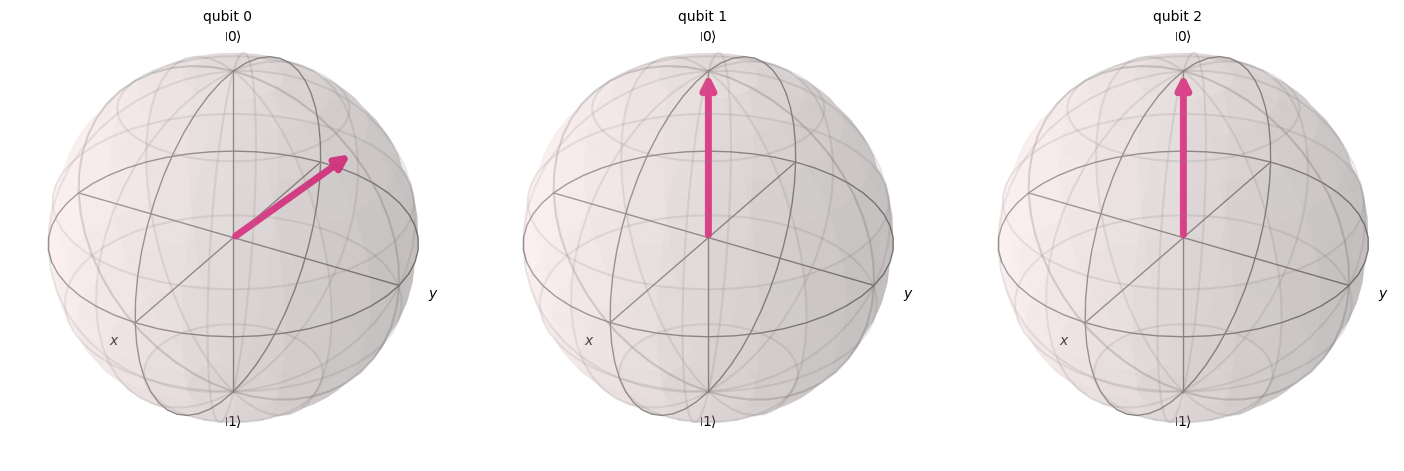


2️⃣ After creating Bell pair (Hadamard on Qubit 1):


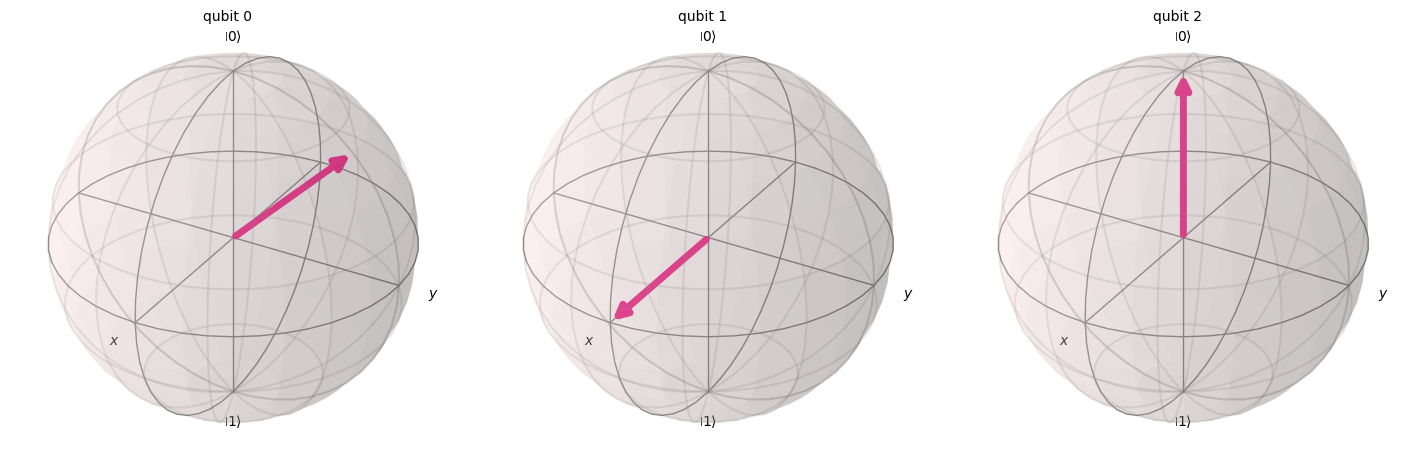


3️⃣ After CNOT (entangling Qubit 1 and Qubit 2):


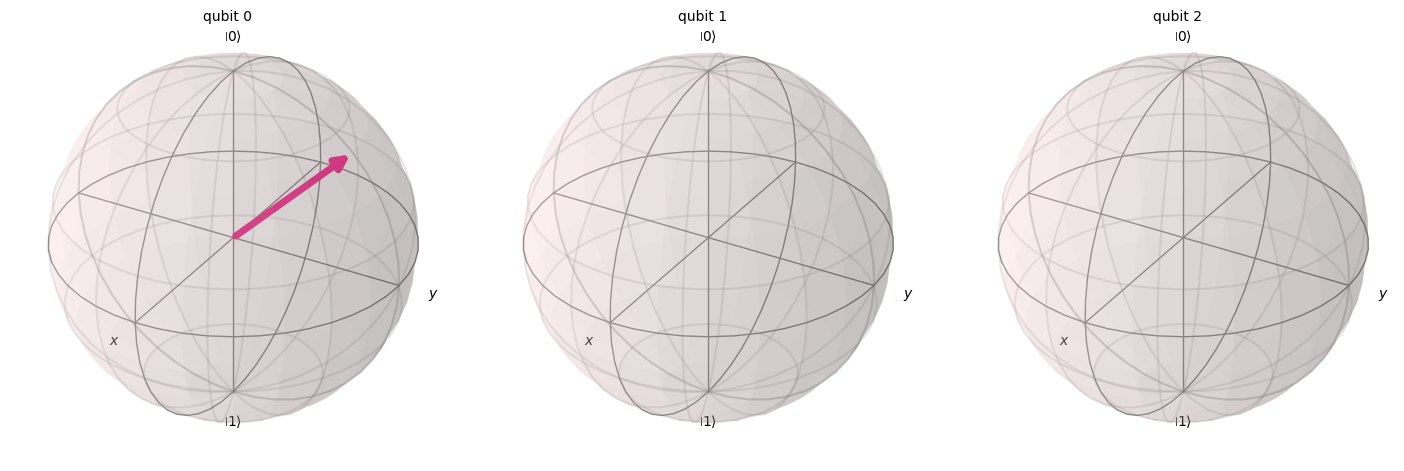


4️⃣ After Bell measurement operations:


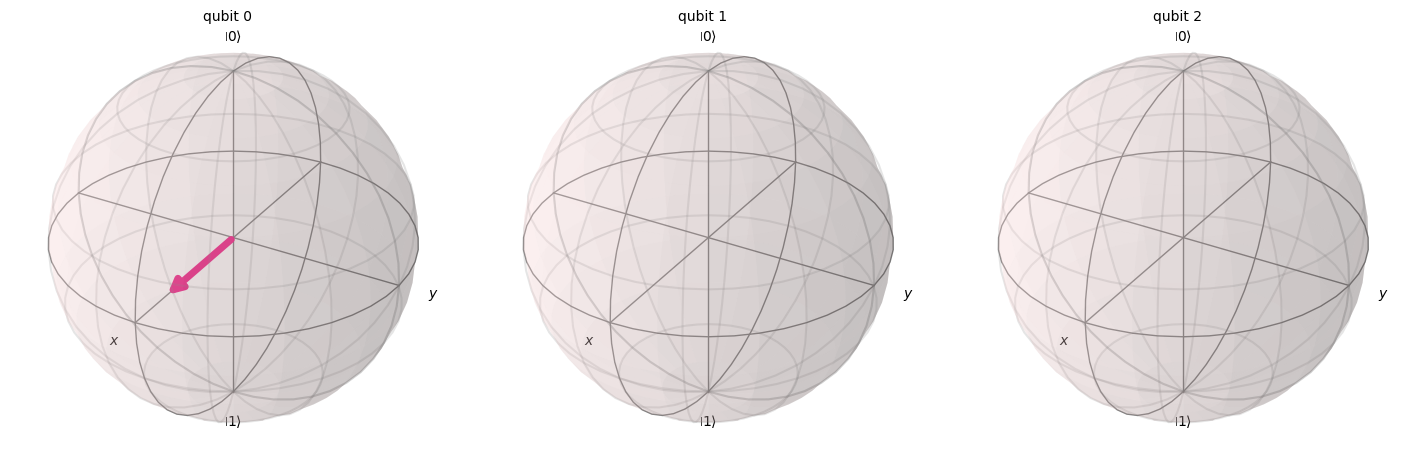


5️⃣ After teleportation corrections (Bob’s qubit ready):


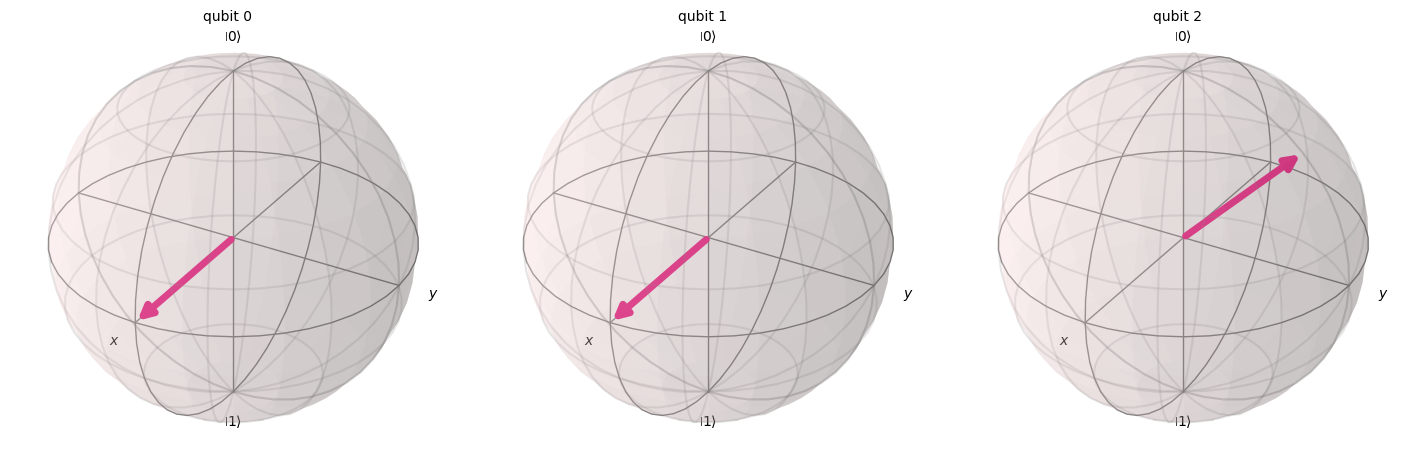


------------------------------------
Fidelity under noisy conditions: 0.933192
Average Fidelity (noiseless): 0.689297


In [16]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace, state_fidelity, DensityMatrix
from qiskit.visualization import plot_bloch_multivector
from qiskit_aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error
import numpy as np
import matplotlib.pyplot as plt


# Task 1: Custom State Teleportation
qc = QuantumCircuit(3, 2)
theta, phi = np.pi / 4, np.pi / 2

qc.ry(theta, 0)
qc.rz(phi, 0)

initial_sv = Statevector.from_instruction(qc)
print("Initial state prepared on Alice’s qubit (Qubit 0):")
display(plot_bloch_multivector(initial_sv))

# Task 2: Add Classical Measurement and Conditional Corrections

qc.h(1)
qc.cx(1, 2)

qc.cx(0, 1)
qc.h(0)
qc.measure([0, 1], [0, 1])

# Conditional operations using if_test (Qiskit 2.x style)
with qc.if_test((qc.cregs[0], 1)):
    qc.x(2)
with qc.if_test((qc.cregs[0], 2)):
    qc.z(2)
with qc.if_test((qc.cregs[0], 3)):
    qc.z(2)
    qc.x(2)

print("\nCircuit with measurement and conditional corrections:")
display(qc.draw("mpl"))


# Task 3: Fidelity Analysis for Multiple Random States

def teleport_and_fidelity(theta, phi):
    circ = QuantumCircuit(3, 2)
    circ.ry(theta, 0)
    circ.rz(phi, 0)
    sv_init = Statevector.from_instruction(circ)

    circ.h(1)
    circ.cx(1, 2)
    circ.cx(0, 1)
    circ.h(0)
    circ.measure([0, 1], [0, 1])

    with circ.if_test((circ.cregs[0], 1)):
        circ.x(2)
    with circ.if_test((circ.cregs[0], 2)):
        circ.z(2)
    with circ.if_test((circ.cregs[0], 3)):
        circ.z(2)
        circ.x(2)

    circ.save_statevector()

    sim = AerSimulator()
    compiled = transpile(circ, sim)
    result = sim.run(compiled).result()
    final_sv = Statevector(result.data(0)["statevector"])

    rho_init = partial_trace(sv_init, [1, 2])
    rho_final = partial_trace(final_sv, [0, 1])
    return state_fidelity(rho_init, rho_final)

# Run teleportation for random states
thetas = np.random.uniform(0, np.pi, 15)
phis = np.random.uniform(0, 2 * np.pi, 15)
fidelities = [teleport_and_fidelity(t, p) for t, p in zip(thetas, phis)]

plt.figure(figsize=(7, 4))
plt.plot(range(1, len(fidelities) + 1), fidelities, 'o-', label='Fidelity')
plt.xlabel("Experiment Number")
plt.ylabel("Fidelity")
plt.title("Quantum Teleportation Fidelity for Random States")
plt.grid(True)
plt.legend()
plt.show()

print(f"Average Fidelity (noiseless): {np.mean(fidelities):.6f}")

# Task 4: Step-by-Step Bloch Sphere Visualization

qc_vis = QuantumCircuit(3)
qc_vis.ry(theta, 0)
qc_vis.rz(phi, 0)

print("\n1️⃣ Initial state (Qubit 0):")
display(plot_bloch_multivector(Statevector.from_instruction(qc_vis)))

qc_vis.h(1)
print("\n2️⃣ After creating Bell pair (Hadamard on Qubit 1):")
display(plot_bloch_multivector(Statevector.from_instruction(qc_vis)))

qc_vis.cx(1, 2)
print("\n3️⃣ After CNOT (entangling Qubit 1 and Qubit 2):")
display(plot_bloch_multivector(Statevector.from_instruction(qc_vis)))

qc_vis.cx(0, 1)
qc_vis.h(0)
print("\n4️⃣ After Bell measurement operations:")
display(plot_bloch_multivector(Statevector.from_instruction(qc_vis)))

qc_vis.cx(1, 2)
qc_vis.cz(0, 2)
print("\n5️⃣ After teleportation corrections (Bob’s qubit ready):")
display(plot_bloch_multivector(Statevector.from_instruction(qc_vis)))

# Task 5: Introduce Noise and Study Fidelity Drop

# Define a noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 1), ['x', 'h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 2), ['cx'])
noise_model.add_all_qubit_quantum_error(amplitude_damping_error(0.03), ['ry', 'rz'])

# Create a teleportation circuit (without classical bits) for noise simulation
qc_noisy = QuantumCircuit(3)
qc_noisy.ry(theta, 0)
qc_noisy.rz(phi, 0)
qc_noisy.h(1)
qc_noisy.cx(1, 2)
qc_noisy.cx(0, 1)
qc_noisy.h(0)
qc_noisy.cx(1, 2)
qc_noisy.cz(0, 2)
qc_noisy.save_density_matrix()

sim_noise = AerSimulator(noise_model=noise_model)
compiled_noisy = transpile(qc_noisy, sim_noise)
result_noisy = sim_noise.run(compiled_noisy).result()

rho_full = DensityMatrix(result_noisy.data(0)["density_matrix"])

# Correct partial trace usage
rho_bob_noisy = partial_trace(rho_full, [0, 1])
rho_init = partial_trace(initial_sv, [1, 2])

noisy_fid = state_fidelity(rho_init, rho_bob_noisy)

print("\n------------------------------------")
print(f"Fidelity under noisy conditions: {noisy_fid:.6f}")
print(f"Average Fidelity (noiseless): {np.mean(fidelities):.6f}")
